Geographic location plot
Counter({1: 224, 0: 171, 4: 44, -1: 26, 5: 13, 6: 9, 2: 8, 3: 5})
          placeid         lng        lat
34710188  7097877  -16.258868  28.456757
29549215  3937348  -43.205988 -22.983168
19241047   690523  153.332448 -27.993513
33398764  6764455  118.790009  32.045460
28964043  3041673  -89.616275  20.967781
Number of clusters =7
Place clustering plot


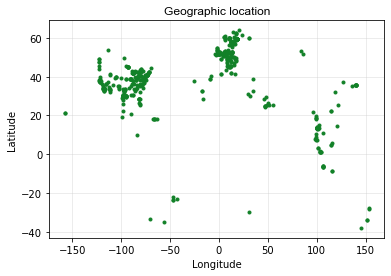

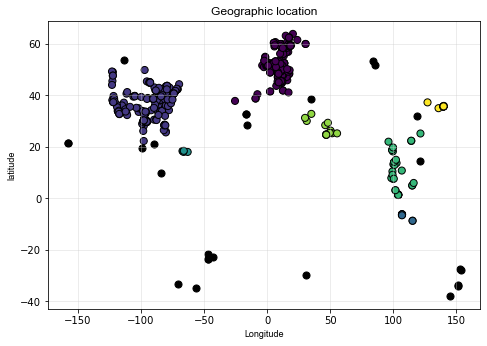

Counter({1: 33, 0: 3, 2: 3, 3: 2, 4: 2})
Number of clusters =4
final clusters


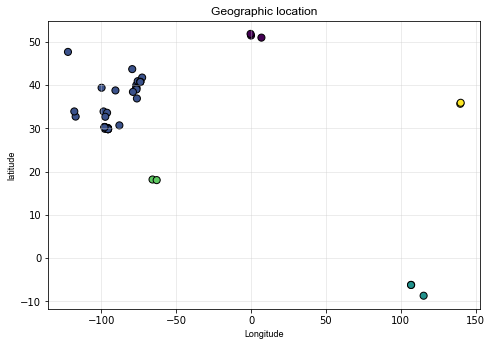

In [5]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from collections import Counter
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

data=pd.read_csv('gowalla_checkins.csv')
del data['datetime']
d=pd.read_csv('gowalla_friendship.csv')
e=pd.read_csv('gowalla_spots_subset1.csv')
e=e.rename(columns={"id":"placeid"})
e.drop(e.columns[[1, 4,5,7,8,9,10,11]], axis = 1, inplace = True)
balanced_data=pd.merge(e,data, on = "placeid", how = "inner")
balanced_data=pd.DataFrame.drop_duplicates(balanced_data)
datal=balanced_data.drop(balanced_data.columns[[3,4]], axis = 1)
place_clustering_data=pd.DataFrame.drop_duplicates(datal)
place_clustering_data.head()
data=place_clustering_data.sample(500)

print('Geographic location plot')

_=plt.plot(data['lng'],data['lat'],marker='.',linewidth=0,color='#128128')
_=plt.grid(which='major',color='#cccccc',alpha=0.45)
_=plt.title('Geographic location',family='Arial',fontsize=12)
_=plt.xlabel('Longitude')
_=plt.ylabel('Latitude')

dbscan_data=data[['lng','lat']]
dbscan_data=dbscan_data.values.astype('float32',copy=False)
dbscan_data_scaler=StandardScaler().fit(dbscan_data)
dbscan_data=dbscan_data_scaler.transform(dbscan_data)
model=DBSCAN(eps=0.25,min_samples=5,metric='euclidean').fit(dbscan_data)
model
outliers_df=data[model.labels_==-1]
clusters_df=data[model.labels_!=-1]
colors=model.labels_
colors_clusters=colors[colors!=-1]
color_outliers='black'
clusters=Counter(model.labels_)
print(clusters)
print(data[model.labels_==-1].head())
print('Number of clusters ={}'.format(len(clusters)-1))

print('Place clustering plot')

fig=plt.figure()
ax=fig.add_axes([.1,.1,1,1])
ax.scatter(clusters_df['lng'],clusters_df['lat'],c=colors_clusters,edgecolors='black',s=50)
ax.scatter(outliers_df['lng'],outliers_df['lat'],c=color_outliers,edgecolors='black',s=50)
ax.set_xlabel('Longitude',family='Arial',fontsize=9)
ax.set_ylabel('latitude',family='Arial',fontsize=9)
plt.title('Geographic location',family='Arial',fontsize=12)
plt.grid(which='major',color='#cccccc',alpha=0.45)
plt.show()

def calculate_contributing_users(p1,p2):
    cu=0
    for i in p1:
        l=d[d['userid1']==i]
        r=l['userid2'].values
        q=set(r).intersection(p2)
        cu=cu+len(q)
    return cu 

def check_social_distance(df,new_clusters_df):
    p1=[]
    p2=[]
    for i in df['placeid']:
        f=balanced_data[balanced_data['placeid']==i]
        p1=f['userid'].values
        sd=[]
        mean=0
        for j in df['placeid']:
            if(i!=j):
                r=balanced_data[balanced_data['placeid']==j]
                p2=r['userid'].values
                k=set(p1).intersection(p2)
                union_p1_p2=len(p1)+len(p2)-len(k)
                q1=set(p1)
                q2=set(p2)
                q1=q1-k
                q2=q2-k
                contributing_users=calculate_contributing_users(q1,q2)
                social_distance=(contributing_users+len(k))/union_p1_p2
                sd.append(social_distance)
                mean=mean+social_distance
        mean_sd=mean/len(df['placeid'])
        #tou value is 0.001 here
        if(mean_sd<0.05):
            df=df.drop(df[df.placeid==i].index)   
    return len(df),df

new_clusters_df=pd.DataFrame()
labels=[]
cluster_no=0
for i in range(len(clusters)-1):
    length,df=check_social_distance(data[model.labels_==i],new_clusters_df)
    for j in range(length):
        labels.append(cluster_no)
    if(len(df)>0):
        cluster_no=cluster_no+1
    new_clusters_df=new_clusters_df.append(df)
new_clusters_df

new_colors=labels
new_colors_clusters=colors[colors!=-1]
new_clusters=Counter(labels)
print(new_clusters)
print('Number of clusters ={}'.format(len(new_clusters)-1))

print('final clusters')

fig=plt.figure()
ax=fig.add_axes([.1,.1,1,1])
ax.scatter(new_clusters_df['lng'],new_clusters_df['lat'],c=new_colors,edgecolors='black',s=50)
ax.set_xlabel('Longitude',family='Arial',fontsize=9)
ax.set_ylabel('latitude',family='Arial',fontsize=9)
plt.title('Geographic location',family='Arial',fontsize=12)
plt.grid(which='major',color='#cccccc',alpha=0.45)
plt.show()